In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
%matplotlib inline
plt.style.use("ggplot")

In [2]:
data = pd.read_csv('./input/data-attendance-2.txt')
data.head()

,PersonID,A,Score,M,Y
0,1,0,69,43,38
1,2,1,145,56,40
2,3,0,125,32,24
3,4,1,86,45,33
4,5,1,158,33,23


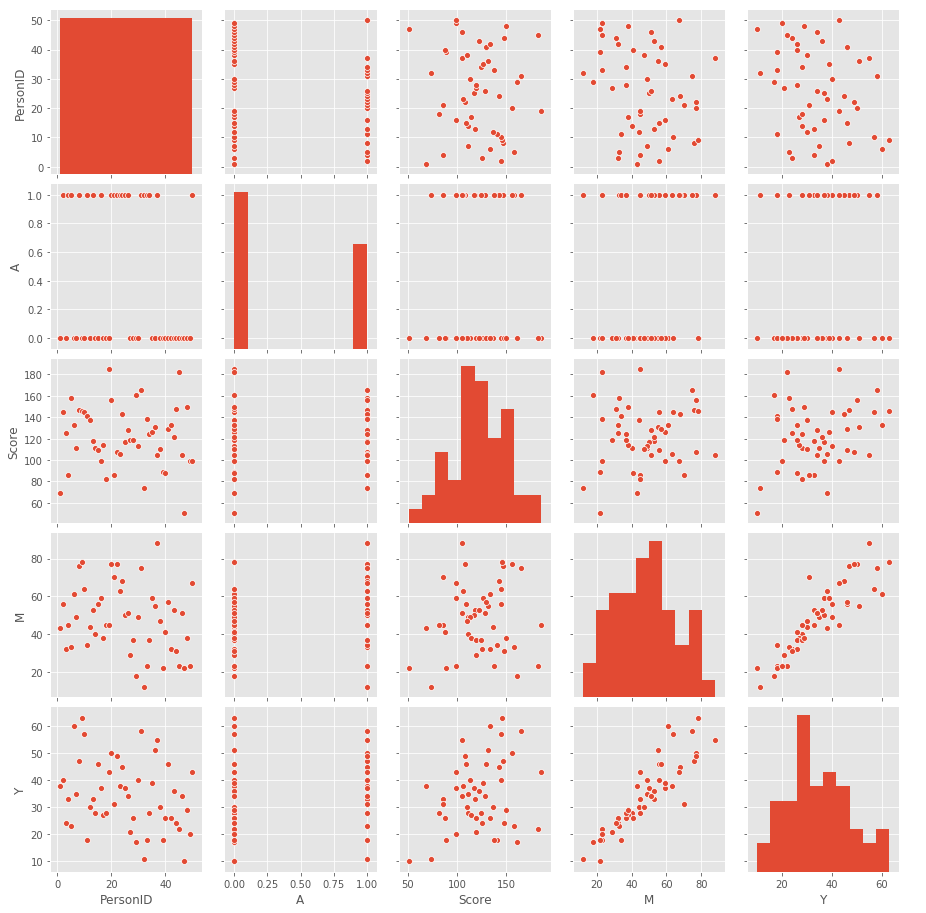

In [3]:
sns.pairplot(data)

In [4]:
data['Score'] = data['Score'] / 200

In [5]:
stan_model = """

data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0> Score[N];
  int<lower=0> M[N];
}

parameters {
  real b[3];
}

transformed parameters {
  real lambda[N];
  for (n in 1:N){
    lambda[n] = exp(b[1] + b[2] * A[n] + b[3] * Score[n]);
  }
}

model {
  for (n in 1:N){
    M[n] ~ poisson(lambda[n]);
  }
}

generated quantities {
  real m_pred[N];
  for (n in 1:N){
    m_pred[n] = poisson_rng(lambda[n]);
  }
}
"""

In [6]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7ff8463a3835de06b0fb20d6bf206d6b NOW.


In [7]:
stan_data = {}
stan_data['N'] = data.shape[0]
stan_data['A'] = data['A']
stan_data['Score'] = data['Score']
stan_data['M'] = data['M']

In [8]:
fit = sm.sampling(stan_data)

In [9]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_7ff8463a3835de06b0fb20d6bf206d6b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]         3.58  2.8e-3    0.1    3.39   3.51   3.57   3.64   3.77   1248    1.0
b[2]         0.26  9.7e-4   0.04    0.18   0.24   0.27   0.29   0.34   1813    1.0
b[3]         0.29  4.2e-3   0.15 -5.2e-3    0.2    0.3   0.39   0.58   1283    1.0
lambda[1]   39.57    0.06    2.0   35.96  38.18  39.47  40.83  43.76   1314    1.0
lambda[2]   57.59    0.04   2.01   53.66  56.28  57.55  58.94  61.53   2112    1.0
lambda[3]   42.91    0.02    1.2   40.64  42.09  42.91  43.67  45.32   2383    1.0
lambda[4]   52.84    0.05   2.11   48.71   51.4  52.85  54.21  57.07   1809    1.0
lambda[5]   58.71    0.06    2.4   53.96  57.13  58.64  60.32  63.49   1807    1.0
lambda[6]   43.41    0.0

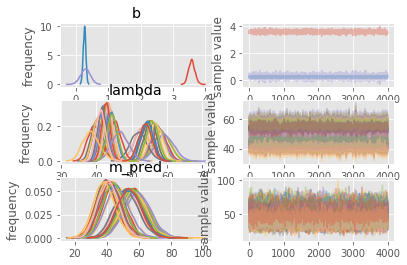

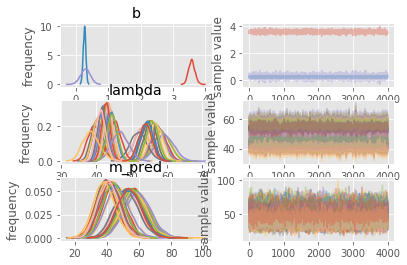

In [10]:
fit.plot()

In [11]:
sample_m_pred = fit.extract('m_pred')['m_pred']
sample_b1 = fit.extract('b')['b'][0]
sample_b2 = fit.extract('b')['b'][1]
sample_b3 = fit.extract('b')['b'][2]
sample_lambda = fit.extract('lambda')['lambda']
sample_lp__ = fit.extract('lp__')['lp__']

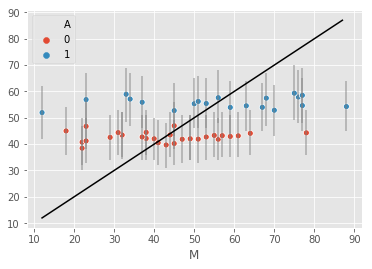

In [12]:
lower80, upper80 = mstats.mquantiles(sample_m_pred, [0.1, 0.9], axis=0)
sample_m_pred_mean = np.mean(sample_m_pred, axis=0)

sns.scatterplot(data['M'], sample_m_pred_mean, hue=data['A'])
lower_dist = sample_m_pred_mean - lower80
upper_dist = upper80 -  sample_m_pred_mean
plt.errorbar(data['M'], sample_m_pred_mean, [lower_dist, upper_dist], ls='', alpha=0.6, color='gray')

x = np.arange(min(data['M']), max(data['M']))
y = x
plt.plot(x, y, color='black')